In [17]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

# Упражнение 3.1

Прочитать пояснения и выполнить примеры в https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/master/code/chap03.ipynb

В примере с утечкой замените окно Хэмминга одним из окон, предоставляемых NumPy, и посмотрите, как они влияют на утечку См. http://docs.scipy.org/doc/numpy/reference/routines.window.html.

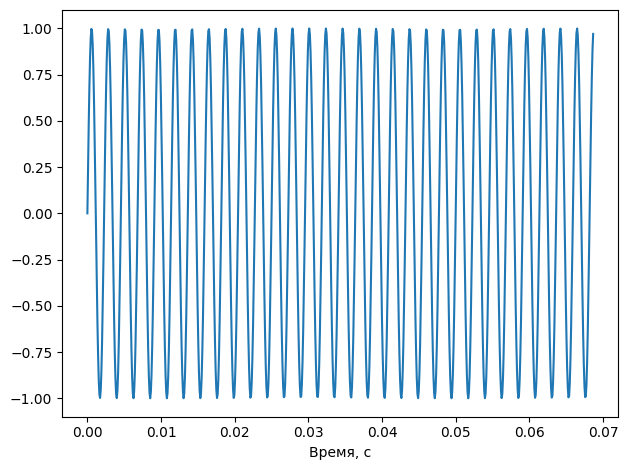

In [18]:
from thinkdsp import SinSignal, decorate

signal = SinSignal(freq=440)
wave = signal.make_wave(signal.period*30.25)
wave.plot()
decorate(xlabel='Время, с')

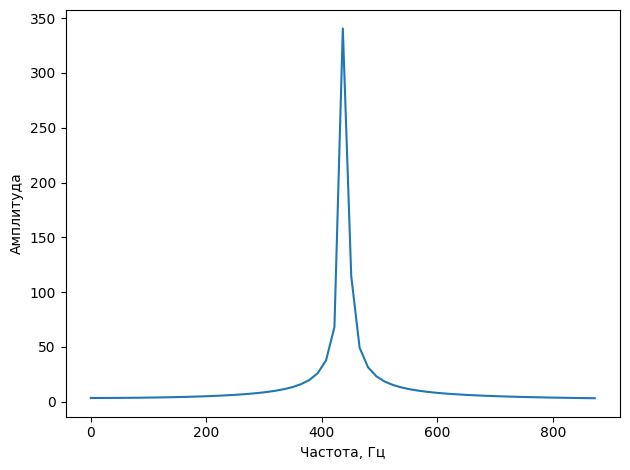

In [19]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Частота, Гц', ylabel='Амплитуда')

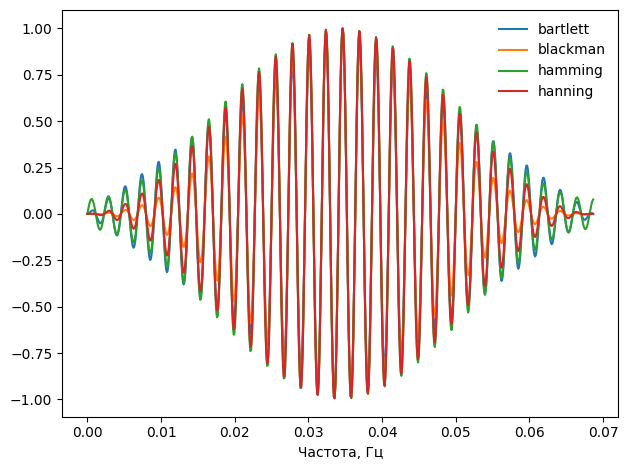

In [20]:
import numpy as np

for fun in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(signal.period*30.25)
    wave.ys *= fun(len(wave.ys))
    wave.plot(label=fun.__name__)
decorate(xlabel='Частота, Гц')

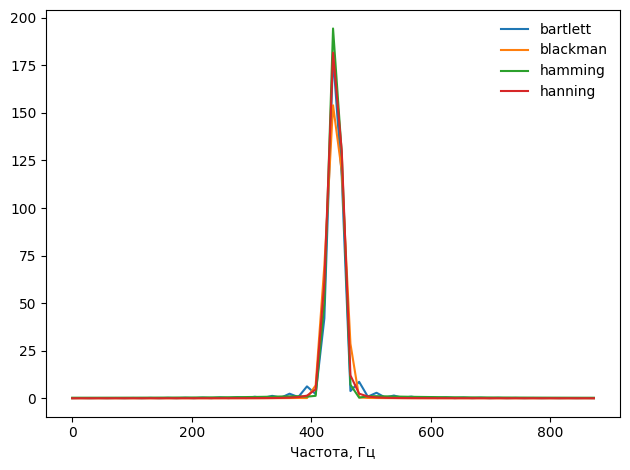

In [21]:
for fun in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(signal.period*30.25)
    wave.ys *= fun(len(wave.ys))
    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=fun.__name__)
decorate(xlabel='Частота, Гц')

Сравнение графиков показывает, что окно Hanning даёт наиболее плавный переход между началом и концом сигнала и даёт более гладкий график спектрограммы.

# Упражнение 3.2

Напишите класс, называемый *SawtoothChirp*, расширяющий *Chirp* и переопределяющий *evaluate* для генерации пилообразного сигнала с линейно увеличивающейся (или уменьшающейся) частотой.

Подсказка: надо совместить функции *evaluate*, *Chirp* и *SawtoothSignal*.

Нарисуйте эскиз спектрограммы этого сигнала, а затем распечатайте её. Эффект биений должен быть очевиден, а если сигнал внимательно прослушать, то биения можно и услышать.

In [22]:
from thinkdsp import Chirp, normalize, unbias

class SawtoothChirp(Chirp):

  def evaluate(self, ts):
    freqs = np.linspace(self.start, self.end, len(ts))
    dts = np.diff(ts, prepend=0)
    dphis = (2 * np.pi) * freqs * dts
    phases = np.cumsum(dphis)
    cycles = phases / (2 * np.pi)
    frac, _ = np.modf(cycles)
    ys = normalize(unbias(frac), self.amp)
    return ys

signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.make_audio()

Достаточно заметно слышны биения.

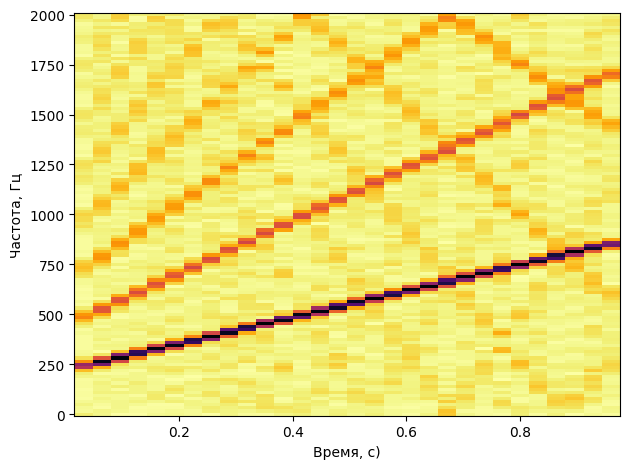

In [23]:
spectogram = wave.make_spectrogram(256)
spectogram.plot()
decorate(xlabel='Время, с)', ylabel='Частота, Гц')

# Упражнение 3.3

Создайте пилообразный чирп, меняющийся от 2500 до 3000 Гц, и на его основе сгенерируйте сигнал длительностью 1 с. и частотой кадров 20 кГц. Нарисуйте, каким примерно будет Spectrum. Затем распечатайте Spectrum и посмотрите, правы ли вы.

Так как у пилообразного сигнала присутствуют все кратные гармоники, то следует ожидать высокую амплитуду в области фундаментальных частота (2500-3000 Гц) и убываюшие по амплитуде кратные гармоники (5000-6000 Гц, 7500-9000 Гц и т. д.).

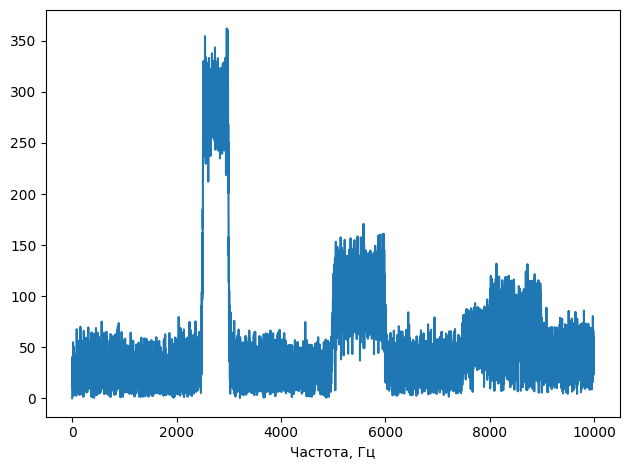

In [24]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_spectrum().plot()
decorate(xlabel='Частота, Гц')

Предположение оказалось верным.

# Упражнение 3.4

В музыкальной терминологии глиссандо - это нота, меняющаяся от одной высоты до другой, то есть своеобразный чирп.

Найдите или запишите звук глиссандо и распечатайте спектрограмму первых нескольких секунд.

In [25]:
from thinkdsp import read_wave

if not os.path.exists('vocal-slide.wav'):
    !wget https://github.com/Ch0rtik/telecom/raw/main/chap_03/vocal-slide.wav

wave = read_wave('vocal-slide.wav')
wave.make_audio()

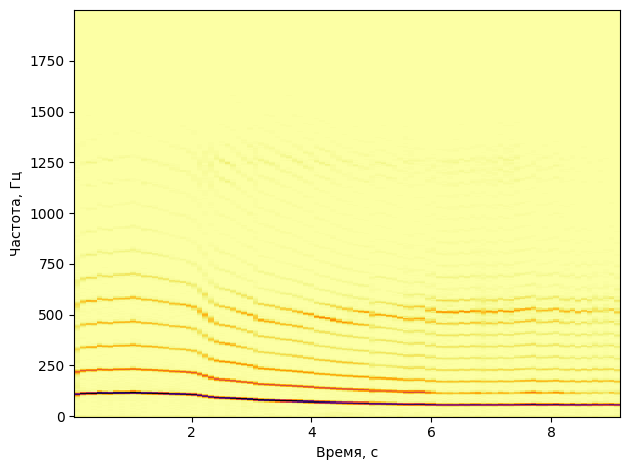

In [26]:
wave.make_spectrogram(8192).plot(2000)
decorate(xlabel='Время, с', ylabel='Частота, Гц')

С помощью данного примера можно увидеть, что для показа графика с частотами гораздо больше подходит логарифмический масштаб – высокие гармоники сдвигаются на большее расстояние, несмотря на то, что все гармоники проходят одинаковый интервал.

# Упражнение 3.5

Тромбонист играет глиссандо, непрерывно дуя в мундштук и двигая кулису тромбона. При этом общая длина трубы меняется, а играемая нота обратно пропорциональна этой длине.

Если предположить, что музыкант двигает кулису с постоянной скоростью, как будет меняться во времени частота?

Напишите класс, называемый TromboneGliss, расширяющий Chirp и предоставляющий evaluate. Создайте сигнал, имитирующий глиссадо на тромбоне от C3 до F3, и обратно до C3. С3 - 262 Гц; F3 - 349 Гц.

Напечатайте спектрограмму полученного сигнала. На что похоже глиссандо на тромбоне - на линейный или же экспоненциальный чирп?

In [27]:
class TromboneGliss(Chirp):

  def evaluate(self, ts):
    freqs = np.linspace(self.start, self.end, len(ts))
    dts = np.diff(ts, prepend=0)
    dphis = (np.pi * 2) * freqs * dts
    phases = np.cumsum(dphis)
    ys = self.amp * np.cos(phases)
    return ys

In [28]:
wave = TromboneGliss(349, 262).make_wave(duration=1) | TromboneGliss(262, 349).make_wave(duration=1)
wave.make_audio()

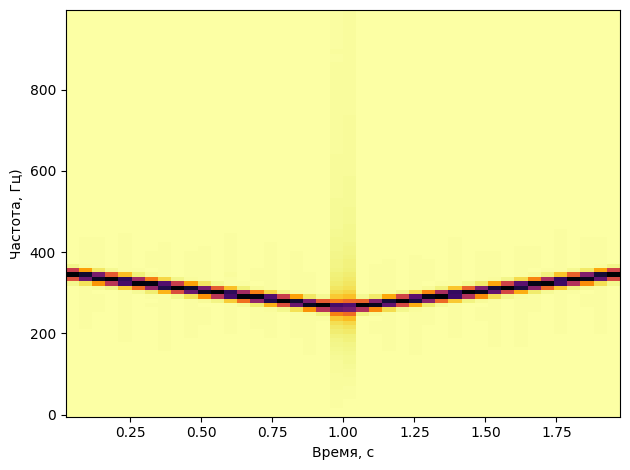

In [29]:
spectrogram = wave.make_spectrogram(1024)
spectrogram.plot(1000)
decorate(xlabel='Время, с', ylabel='Частота, Гц)')

Спетрограмма больше похожа на линейный чирп. В записи и спектрограмме пристутствует щелчок в середине, вызванный склейкой двух записей.

# Упражнение 3.6

Сделайте или найдите запись серии гласных звуков и посмотрите на спектрограмму. Сможете ли вы различить разные гласные?

Записи гласных были взяты из набора фонетического алфавита на Википедии.

In [30]:
from thinkdsp import read_wave

if not os.path.exists('vowels.wav'):
    !wget https://github.com/Ch0rtik/telecom/raw/main/chap_03/vowels.wav

wave = read_wave('vowels.wav')
wave.make_audio()

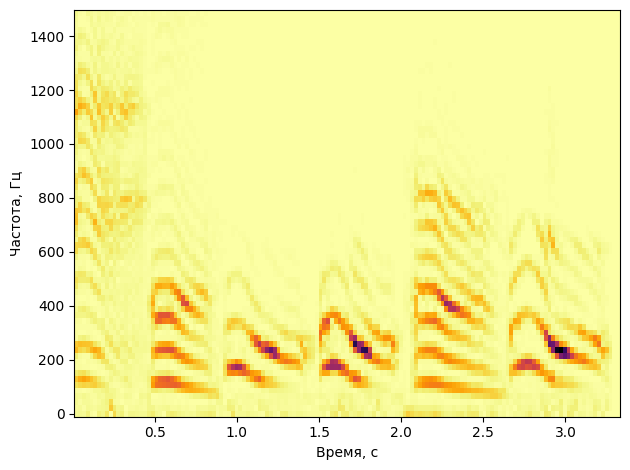

In [31]:
wave.make_spectrogram(2048).plot(high=1500)
decorate(xlabel='Время, с', ylabel='Частота, Гц')

Визуальное распознавание гласных на основе спектрограммы не представляется возможным на первый взгляд, хотя можно увидеть отличия в спектре для каждого из гласных.